In [23]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")
random.seed(30)


df = pd.read_csv("data/us_change.csv", index_col=0)
print(df.columns)
df

Index(['Quarter', 'Consumption', 'Income', 'Production', 'Savings',
       'Unemployment'],
      dtype='object')


,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [24]:
# Separando as features e o target
X_data = df.drop(columns=["Quarter", "Consumption"]).values
y_data = df["Consumption"].values.reshape(-1, 1)

# Normalizando as features e o target separadamente
scaler_X = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X_data)

scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(y_data)

In [25]:
# Criando a função para gerar as sequências para a LSTM
def create_sequences(features, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i + sequence_length, :])
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [26]:
# Definindo os parâmetros
sequence_length = 5
X, y = create_sequences(scaled_X, scaled_y, sequence_length)

# Dividindo os dados em treino e teste
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

units = 50
# print(X_train.shape)
input_size, num_features = X_train.shape[1], X_train.shape[2]

# Construindo o modelo LSTM
model = Sequential()
model.add(Input(shape=(input_size, num_features)))
model.add(LSTM(units=units, activation='relu'))
model.add(Dense(1))

In [27]:
# Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

# Treinando o modelo
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=8, verbose=1
)

# Avaliando o modelo no conjunto de teste
loss = model.evaluate(X_test, y_test)
print(f"Loss no conjunto de teste: {loss}")

# Fazendo previsões
X_test = np.array(X_test)
y_pred = model.predict(X_test)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3632  
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0576
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0267
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0225 
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0218 
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0248
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0259 
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232 
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0202
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0185
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0208 
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0236 
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0270
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0216 
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0218 
Epoch

In [28]:
# Invertendo a escala do target
y_test_original = scaler_y.inverse_transform(y_test)
y_pred_original = scaler_y.inverse_transform(y_pred)

# Calculando as métricas
mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

# Calculando o MASE
def mean_absolute_scaled_error(y_true, y_pred, y_train_original):
    naive_forecast_errors = np.abs(np.diff(y_train_original.flatten()))
    mae_naive = np.mean(naive_forecast_errors)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

# Invertendo a escala de y_train para o cálculo do MASE
y_train_original = scaler_y.inverse_transform(y_train)

mase_original = mean_absolute_scaled_error(y_test_original, y_pred_original, y_train_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"Mean Absolute Error (MAE) na escala original: {mae_original}")
print(f"Root Mean Squared Error (RMSE) na escala original: {rmse_original}")
print(f"Mean Absolute Scaled Error (MASE): {mase_original}")
print(f"R²: {r2}")

Mean Absolute Error (MAE) na escala original: 0.3378306200685604
Root Mean Squared Error (RMSE) na escala original: 0.4438004423646636
Mean Absolute Scaled Error (MASE): 0.5607428288490762
R²: -0.9857166712226857


[]

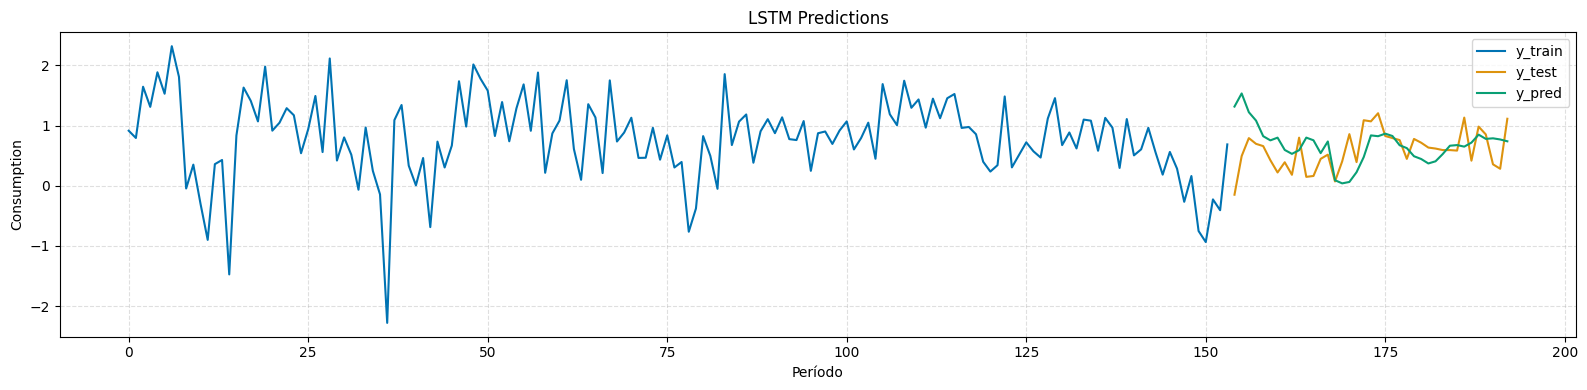

In [29]:
import matplotlib.pyplot as plt

train_time = np.arange(len(y_train_original))
test_time = np.arange(len(y_train_original), len(y_train_original) + len(y_test_original))

plt.figure(figsize=(16, 4))

plt.plot(train_time, y_train_original, label="y_train", color='#0073b3')
plt.plot(test_time, y_test_original, label="y_test", color='#dd930e')
plt.plot(test_time, y_pred_original, label="y_pred", color='#099f74')

plt.title("LSTM Predictions")
plt.xlabel("Período")
plt.ylabel("Consumption")
plt.grid(linestyle='--', alpha=0.4, zorder=5)
plt.legend()
plt.tight_layout()
plt.plot()